In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Tratamento de warning
import warnings
warnings.filterwarnings('ignore')

### ABRINDO DF APÓS EDA E TRATAMENTOS

In [3]:
%store -r datatran

In [4]:
df = datatran

In [5]:
df.columns

Index(['id', 'ano', 'feriado', 'mes', 'data_inversa', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'classificacao_acidente', 'veiculos',
       'condicao_metereologica', 'fase_dia', 'dia_semana', 'tipo_acidente',
       'tipo_pista', 'mortos', 'feridos_graves', 'latitude', 'longitude',
       'status', 'regiao', 'periodo'],
      dtype='object')

### COM BASE MES, FERIADO, CLIMA, RODOVIA E UF -> SABER SE ESTRADA PERIGOSA OU NÃO -> RISCO
QUANDO BASE DE DADOS RECEBER NOVOS DADOS -> CLASSIFICAR

In [6]:
colunas_para_remover = ['id', 'ano', 'mes', 'uf', 'data_inversa', 'km', 'municipio', 'causa_acidente', 'classificacao_acidente', 'veiculos', 'dia_semana', 'tipo_acidente', 'tipo_pista', 'mortos', 'feridos_graves', 'latitude', 'longitude', 'condicao_metereologica',]
df_model = df.drop(colunas_para_remover, axis=1)

In [7]:
rows, cols = df_model.shape
print(f'Linhas: {rows}. Colunas: {cols}')

Linhas: 19995. Colunas: 6


In [8]:
df_model.columns

Index(['feriado', 'br', 'fase_dia', 'status', 'regiao', 'periodo'], dtype='object')

In [9]:
df_model.head(1)

,feriado,br,fase_dia,status,regiao,periodo
0,n,230,Plena Noite,Perigosa,Norte,1 Trimestre


### Normalizando os dados

- Usar One-Hot Encoding: dados categóricos que não têm ordem


In [10]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar One-Hot Encoding nas variáveis categóricas
categorical_cols = ['feriado', 'br', 'fase_dia', 'regiao', 'periodo']
df_encoded = pd.get_dummies(df_model, columns=categorical_cols)

In [11]:
df_encoded.head(1)

,status,feriado_n,feriado_y,br_0,br_10,br_101,br_104,br_110,br_116,br_122,...,fase_dia_Plena Noite,fase_dia_Pleno dia,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,periodo_1 Trimestre,periodo_2 Trimestre,periodo_3 Trimestre
0,Perigosa,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


### Separando os dados em treino e teste

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [13]:
X = df_encoded.drop('status', axis=1)
y = df_encoded['status']

#### Equilibrando a target

In [14]:
y.value_counts(normalize=True)*100

Segura      66.981745
Perigosa    33.018255
Name: status, dtype: float64

In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [16]:
y_resampled.value_counts(normalize=True)*100

Perigosa    50.0
Segura      50.0
Name: status, dtype: float64

### Separando os dados em treino e teste

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

### GRID SEARCH para encontrar o melhor modelo e hiperparâmetros

- devido a problemas de performance, grid search simples para "simular" seu uso.

Foram rodadas várias combinações de modelos e hiperparâmetros, mas como a performance do modelo foi moderada:
Acurácia: 0.6363806701074829
Precisão: 0.6363806701074829
Revocação: 0.6363806701074829
F1-Score: 0.6363806701074829
Foi ajustado o dado, transformando as colunas mes e uf e o modelo foi treinado novamente.

In [18]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
# Definir a validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelos e primeiros parâmetros para rápida avaliação
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100], 'max_depth': [10, 20], 'class_weight': ['balanced']}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.2]}
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1], 'solver': ['lbfgs', 'liblinear']}
    }
}

# Executar GridSearchCV com validação cruzada
best_models = {}

for model_name, model_data in models_params.items():
    print(f"Treinando {model_name} com validação cruzada...")

    grid_search = GridSearchCV(model_data['model'], model_data['params'], cv=cv_strategy, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)  

    scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv_strategy, scoring='accuracy')

    print(scores)
    print(f"Acurácia média com validação cruzada para {model_name}: {scores.mean():.4f}")

    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}\n")

print("Modelos validados e prontos para refinamento.")

Treinando RandomForest com validação cruzada...
[0.55749129 0.55674465 0.55873569 0.55425585 0.55439383]
Acurácia média com validação cruzada para RandomForest: 0.5563
Melhores parâmetros para RandomForest: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100}

Treinando GradientBoosting com validação cruzada...
[0.56694873 0.55350921 0.55998009 0.55674465 0.54991287]
Acurácia média com validação cruzada para GradientBoosting: 0.5574
Melhores parâmetros para GradientBoosting: {'learning_rate': 0.2, 'n_estimators': 100}

Treinando LogisticRegression com validação cruzada...
[0.57167745 0.56470881 0.55774017 0.55973121 0.56260891]
Acurácia média com validação cruzada para LogisticRegression: 0.5633
Melhores parâmetros para LogisticRegression: {'C': 1, 'solver': 'lbfgs'}

Modelos validados e prontos para refinamento.


In [20]:
best_model_name = max(best_models, key=lambda model: cross_val_score(best_models[model], X_train, y_train, cv=cv_strategy, scoring='accuracy').mean())
best_model = best_models[best_model_name]

print(f"O melhor modelo é: {best_model_name}")

O melhor modelo é: LogisticRegression


In [21]:
y_pred = best_model.predict(X_test)

print(f"Previsões realizadas com {best_model_name}!")

Previsões realizadas com LogisticRegression!


In [22]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, y_pred):.4f}")
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))

Acurácia no conjunto de teste: 0.5622
Relatório de classificação:
              precision    recall  f1-score   support

    Perigosa       0.61      0.40      0.48      3414
      Segura       0.54      0.73      0.62      3283

    accuracy                           0.56      6697
   macro avg       0.57      0.57      0.55      6697
weighted avg       0.57      0.56      0.55      6697



### Melhorando o modelo

In [23]:
param_grid = {
    'C': [0.1, 1, 10],  
    'solver': ['lbfgs', 'liblinear', 'saga'],  
    'max_iter': [100, 200, 500]
}

grid_search_refined = GridSearchCV(best_model, param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
grid_search_refined.fit(X_train, y_train)

best_model_refined = grid_search_refined.best_estimator_
print(f"Novos melhores parâmetros: {grid_search_refined.best_params_}")

Novos melhores parâmetros: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}


In [24]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve

# Converter os rótulos categóricos em 0 e 1
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()
y_probs = best_model_refined.predict_proba(X_test)[:, 1]  # Pegando a probabilidade da classe positiva

# Precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_probs)

# Testar diferentes limiares
for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    print(f"Threshold {threshold:.2f}: Acurácia = {accuracy_score(y_test_binary, y_pred_threshold):.4f}")

Threshold 0.33: Acurácia = 0.5217
Threshold 0.33: Acurácia = 0.5220
Threshold 0.33: Acurácia = 0.5222
Threshold 0.33: Acurácia = 0.5225
Threshold 0.34: Acurácia = 0.5235
Threshold 0.34: Acurácia = 0.5240
Threshold 0.34: Acurácia = 0.5237
Threshold 0.34: Acurácia = 0.5241
Threshold 0.34: Acurácia = 0.5243
Threshold 0.34: Acurácia = 0.5244
Threshold 0.34: Acurácia = 0.5243
Threshold 0.35: Acurácia = 0.5246
Threshold 0.35: Acurácia = 0.5256
Threshold 0.35: Acurácia = 0.5259
Threshold 0.36: Acurácia = 0.5271
Threshold 0.36: Acurácia = 0.5273
Threshold 0.36: Acurácia = 0.5277
Threshold 0.36: Acurácia = 0.5286
Threshold 0.36: Acurácia = 0.5283
Threshold 0.37: Acurácia = 0.5281
Threshold 0.37: Acurácia = 0.5289
Threshold 0.37: Acurácia = 0.5287
Threshold 0.37: Acurácia = 0.5286
Threshold 0.37: Acurácia = 0.5287
Threshold 0.37: Acurácia = 0.5287
Threshold 0.37: Acurácia = 0.5286
Threshold 0.37: Acurácia = 0.5286
Threshold 0.37: Acurácia = 0.5281
Threshold 0.38: Acurácia = 0.5283
Threshold 0.38

              precision    recall  f1-score   support

    Perigosa       0.61      0.40      0.48      3414
      Segura       0.54      0.73      0.62      3283

    accuracy                           0.56      6697
   macro avg       0.57      0.57      0.55      6697
weighted avg       0.57      0.56      0.55      6697



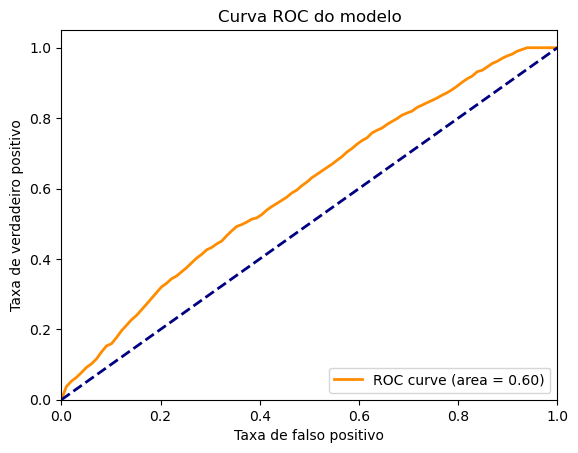

[[1354 2060]
 [ 872 2411]]


In [25]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

grid_search_refined.fit(X_train, y_train)

y_pred_probs = best_model_refined.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_probs)
roc_auc = auc(fpr, tpr)


fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr_smooth, tpr_smooth, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC do modelo')
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)

In [26]:
y_pred = best_model_refined.predict(X_test)

In [27]:
# 5 primeiras previsões das classes pelo modelo
print(y_pred[:5])

['Perigosa' 'Segura' 'Segura' 'Perigosa' 'Segura']


In [28]:
# 5 primeiras classes reais
print(y_test[:5])

20157    Perigosa
19057      Segura
20009    Perigosa
14695      Segura
6730     Perigosa
Name: status, dtype: object


In [29]:
df_completo = X_test.copy()
df_completo['y_real'] = y_test
df_completo['y_predito'] = y_pred

In [30]:
df_completo.head(1)

,feriado_n,feriado_y,br_0,br_10,br_101,br_104,br_110,br_116,br_122,br_135,...,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,periodo_1 Trimestre,periodo_2 Trimestre,periodo_3 Trimestre,y_real,y_predito
20157,1,0,0,0,0,0,0,0,0,209,...,0,1,0,0,0,1,0,0,Perigosa,Perigosa


In [31]:
# Calculando métricas de desempenho (acurácia, precisão, revocação e F1-Score)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

In [32]:
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("F1-Score:", f1)

Acurácia: 0.5621920262804241
Precisão: 0.5621920262804241
Revocação: 0.5621920262804241
F1-Score: 0.5621920262804241


### Fazendo previsões com o modelo treinado

In [59]:
# Criando novos dados fictícios
df_novo = pd.DataFrame({
    'feriado': ['n', 'y', 'n', 'y', 'n'],
    'br': [230, 30, 101, 420, 484],
    'fase_dia': ['Manhã', 'Tarde', 'Anoitecer', 'Madrugada', 'Plena Noite'],
    'regiao': ['Norte', 'Nordeste', 'Nordeste', 'Sudeste', 'Sudeste'],
    'periodo': [2, 4, 3, 1, 1]    
})

print(df_novo)

  feriado   br     fase_dia    regiao  periodo
0       n  230        Manhã     Norte        2
1       y   30        Tarde  Nordeste        4
2       n  101    Anoitecer  Nordeste        3
3       y  420    Madrugada   Sudeste        1
4       n  484  Plena Noite   Sudeste        1


### Normalizando os dados novos

In [60]:
# Aplicar One-Hot Encoding nos novos dados
df_novo_encoded = pd.get_dummies(df_novo, columns=categorical_cols)

# Adicionar colunas que faltam para igualar ao modelo treinado
missing_cols = set(df_encoded.columns) - set(df_novo_encoded.columns)
for col in missing_cols:
    df_novo_encoded[col] = 0  # Adiciona colunas ausentes com zero

# Garantir que as colunas estão na mesma ordem
df_novo_encoded = df_novo_encoded[df_encoded.columns]
X_novo = df_novo_encoded.drop('status', axis=1)

print("Agora os novos dados têm as mesmas colunas que o treino!")

Agora os novos dados têm as mesmas colunas que o treino!


In [61]:
X_novo

,feriado_n,feriado_y,br_0,br_10,br_101,br_104,br_110,br_116,br_122,br_135,...,fase_dia_Plena Noite,fase_dia_Pleno dia,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,periodo_1 Trimestre,periodo_2 Trimestre,periodo_3 Trimestre
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [62]:
y_novo_pred = best_model_refined.predict(X_novo)
print("Novas previsões:", y_novo_pred)


Novas previsões: ['Segura' 'Segura' 'Segura' 'Segura' 'Segura']


In [63]:
y_novo_probs = best_model_refined.predict_proba(X_novo)
print("Probabilidades de previsão:", y_novo_probs)


Probabilidades de previsão: [[0.24631901 0.75368099]
 [0.16239441 0.83760559]
 [0.36288415 0.63711585]
 [0.10172432 0.89827568]
 [0.42414763 0.57585237]]


### SALVANDO O MODELO

In [65]:
import joblib

# Salvar o modelo treinado
joblib.dump(best_model_refined, './resultados/modelo_treinado.pkl')

['./resultados/modelo_treinado.pkl']

In [67]:
# Carregar o modelo salvo e fazer previsões
modelo_carregado = joblib.load('./resultados/modelo_treinado.pkl')
y_novo_pred = modelo_carregado.predict(X_novo)
print("Previsões do modelo carregado:", y_novo_pred)

Previsões do modelo carregado: ['Segura' 'Segura' 'Segura' 'Segura' 'Segura']
